# Fashion Mnist

Gruppo: Baccoli, Guttilla, Trovato, Turco

https://github.com/zalandoresearch/fashion-mnist#get-the-data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import keras
from tensorflow import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import load_model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

Using TensorFlow backend.


## 1. Load data and exploration

-  Dataset loading from keras and import of training images and labels and test images and labels.

In [2]:
(orig_train_images, orig_train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

- Visualization of some of the images and some statistics on the dataset.

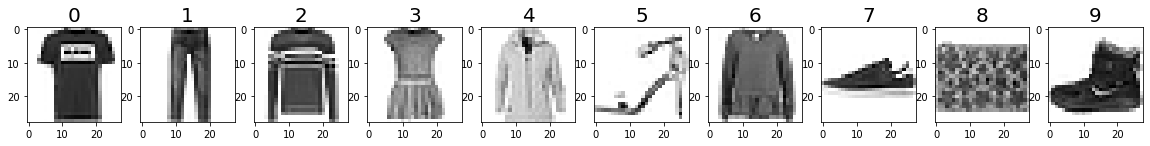

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20,10))

images_labels_indexes = list()
for i in np.unique(orig_train_labels):
    images_labels_indexes.append((i, np.where(orig_train_labels == i)[0][0]))
    
for pos, l_i in enumerate(images_labels_indexes):
    axes[pos].imshow(orig_train_images[l_i[1]], cmap="gray_r")
    axes[pos].set_title(str(l_i[0]), fontsize=20)

plt.show()

- We obtained a numpy array with 60000 images of 28x28 pixels e 60000 labels for the training set and another numpy array with 10000 images of the same size with the corresponding labels. 

In [4]:
columns = ['set','shape'] + [str(l) for l in np.unique(orig_train_labels)]
data = [['train', orig_train_images.shape] + list(np.unique(orig_train_labels, return_counts=True)[1])]
data.append(['test', test_images.shape] + list(np.unique(test_labels, return_counts=True)[1]))
df = pd.DataFrame(data, columns= columns).set_index('set')
df

,shape,0,1,2,3,4,5,6,7,8,9
set,,,,,,,,,,,
train,"(60000, 28, 28)",6000,6000,6000,6000,6000,6000,6000,6000,6000,6000
test,"(10000, 28, 28)",1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


- Split the training set into a new smaller training set and validation set

In [5]:
train_images, val_images, train_labels, val_labels = train_test_split(
    orig_train_images,
    orig_train_labels,
    test_size=0.20,
    random_state=42,
    stratify = orig_train_labels
)

#data
data = [['train', train_images.shape] + list(np.unique(train_labels, return_counts=True)[1])]
data.append(['validation', val_images.shape] + list(np.unique(val_labels, return_counts=True)[1]))
data.append(['test', test_images.shape] + list(np.unique(test_labels, return_counts=True)[1]))
df = pd.DataFrame(data, columns= columns).set_index('set')
df

,shape,0,1,2,3,4,5,6,7,8,9
set,,,,,,,,,,,
train,"(48000, 28, 28)",4800,4800,4800,4800,4800,4800,4800,4800,4800,4800
validation,"(12000, 28, 28)",1200,1200,1200,1200,1200,1200,1200,1200,1200,1200
test,"(10000, 28, 28)",1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


In [6]:
NUM_CLASSES = len(np.unique(test_labels))
WIDTH = train_images.shape[1]
HEIGHT = train_images.shape[2]

### Utils

In [7]:
def plot_training_history(hist):    
    fig, axes = plt.subplots(figsize=(6,6))

    axes.plot(hist.history['loss'], label='Loss', color='blue', ls='-')
    axes.plot(hist.history['val_loss'], label='Val Loss', color='blue', ls='--')

    axes.plot(hist.history['accuracy'], label='Accuracy', color='red', ls='-')
    axes.plot(hist.history['val_accuracy'], label='Val Accuracy', color='red', ls='--')

    axes.set_title("Training History", fontsize=18)
    axes.set_xlabel("Epochs", fontsize=18)
    axes.legend(fontsize=20)

    plt.show()
    return

def prediction_result(model, test_images, test_labels):
    # convert form prediction to id
    y_pred = model.predict(test_images)
    y_pred = np.argmax(y_pred, axis=1) # argmax along axis 1

    # convert from on-hot to original 
    # (we could take the original)
    y_true = np.argmax(test_labels, axis=1) # argmax along axis 1

    print ("Accuracy on test set: {:.3f}".format(accuracy_score(y_true, y_pred)))

    # compute confusion matrix
    print ("\nConfusion Matrix")
    print ( confusion_matrix(y_true, y_pred) )

    # compute classification report
    print ("\nClassification Report")
    print ( classification_report(y_true, y_pred) )
    return

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)

## 2. Baseline model

In [8]:
# parameters
num_pixels = WIDTH * HEIGHT

# transformation
basic_train_images = train_images.reshape(train_images.shape[0], train_images.shape[1]*train_images.shape[2])
basic_train_labels = to_categorical(train_labels)
basic_test_images  = test_images.reshape(test_images.shape[0], test_images.shape[1]*test_images.shape[2])
basic_test_labels  = to_categorical(test_labels)
basic_val_images   = val_images.reshape(val_images.shape[0], val_images.shape[1]*val_images.shape[2])
basic_val_labels   = to_categorical(val_labels)

# define model
model = Sequential()
model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu')) #????????
model.add(Dense(NUM_CLASSES, kernel_initializer='normal', activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                7850      
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


In [9]:
# fit the model
hist = model.fit(
    basic_train_images,
    basic_train_labels,
    validation_data = (basic_val_images, basic_val_labels),
    callbacks = [early_stopping],
    epochs=20, batch_size=200, verbose=0
)

# final evaluation of the model
scores = model.evaluate(basic_val_images, basic_val_labels, verbose=0)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Baseline Error: 14.76%


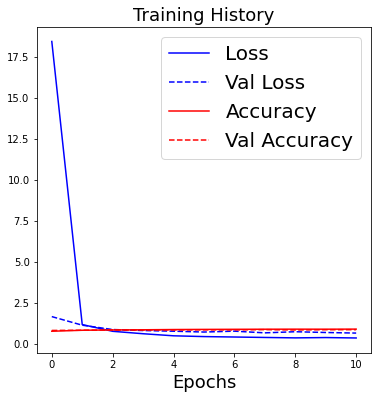

In [10]:
plot_training_history(hist)

In [11]:
prediction_result(model, basic_test_images, basic_test_labels)

Accuracy on test set: 0.845

Confusion Matrix
[[744   4  40  36   8   2 145   1  20   0]
 [  3 965   2  20   6   0   3   0   1   0]
 [  8   5 726  13 170   1  68   0   8   1]
 [ 43  15  22 827  52   0  29   0  10   2]
 [  1   0  81  29 819   0  61   0   9   0]
 [  0   0   1   0   0 948   0  36   2  13]
 [108   3 104  34 143   1 586   0  21   0]
 [  0   0   0   0   0  17   0 911   0  72]
 [  3   0   2   5   7   6   8   9 959   1]
 [  1   0   0   1   0  13   0  18   1 966]]

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1000
           1       0.97      0.96      0.97      1000
           2       0.74      0.73      0.73      1000
           3       0.86      0.83      0.84      1000
           4       0.68      0.82      0.74      1000
           5       0.96      0.95      0.95      1000
           6       0.65      0.59      0.62      1000
           7       0.93      0.91      0.92      1000
           8 

## 3. Convolutional Neural Network

#### Data transformation

In [12]:
def transform_data(images, labels):
    num_images, img_x, img_y = images.shape
    
    # linearize images
    new_images = images.reshape((num_images, WIDTH, HEIGHT, 1))
    new_images = new_images.astype("float64") / 255.0
    
    # one-hot-encoding of labels
    new_labels = to_categorical(labels)
    
    return new_images, new_labels

#transform data
x_orig_train, y_orig_train = transform_data(orig_train_images, orig_train_labels)
x_train, y_train = transform_data(train_images, train_labels)
x_val,   y_val   = transform_data(val_images, val_labels)
x_test,  y_test  = transform_data(test_images,  test_labels)

### 3.1 First model - Crossvalidation

In [13]:
def get_first_model():
    model = Sequential()
    model.add( Conv2D(32, (3, 3), input_shape=(WIDTH, HEIGHT, 1))) 
    model.add( Activation("relu") )
    model.add( MaxPooling2D((2, 2)) )

    model.add( Conv2D(64, (3, 3)) )
    model.add( Activation("relu") )
    model.add( MaxPooling2D((2, 2)) )

    model.add( Flatten() )

    model.add( Dropout(0.5) )

    model.add( Dense(128) )
    model.add( Activation("relu") )

    model.add( Dense(NUM_CLASSES) )
    model.add( Activation("softmax") )
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [14]:
model = get_first_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)             

#### Fitting and evaluation by training and validation sets 

In [15]:
# train the network
hist = model.fit( 
    x_train, 
    y_train, 
    epochs=20,     
    verbose=0, 
    validation_data=(x_val, y_val), 
    batch_size=64,
    callbacks=[early_stopping]
)

scores = model.evaluate(x_val, y_val, verbose=0)
print("First CNN Error: %.2f%%" % (100-scores[1]*100))

First CNN Error: 7.96%


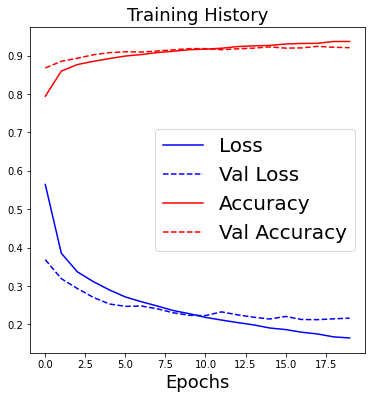

In [16]:
plot_training_history(hist)

In [17]:
model = get_first_model()
hist = model.fit(x_train, y_train, epochs=11, batch_size=32, verbose=0)

prediction_result(model, x_test, y_test)

Accuracy on test set: 0.905

Confusion Matrix
[[796   0  10  29   4   1 157   0   3   0]
 [  3 974   0  12   6   0   3   0   2   0]
 [ 16   0 775  10 114   0  85   0   0   0]
 [  7   3   5 937  28   0  20   0   0   0]
 [  0   0  13  20 913   0  53   0   1   0]
 [  0   0   0   0   0 986   0  12   0   2]
 [ 62   0  47  35  83   0 769   0   4   0]
 [  0   0   0   0   0  10   0 977   0  13]
 [  1   0   1   2   5   1   9   2 978   1]
 [  0   0   0   0   0  10   0  40   0 950]]

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.80      0.84      1000
           1       1.00      0.97      0.99      1000
           2       0.91      0.78      0.84      1000
           3       0.90      0.94      0.92      1000
           4       0.79      0.91      0.85      1000
           5       0.98      0.99      0.98      1000
           6       0.70      0.77      0.73      1000
           7       0.95      0.98      0.96      1000
           8 

#### Crossvalidation then fit the model by all the original training set

In [19]:
scores = []
histories = []

i = 1
kfold = KFold(5, shuffle=True, random_state=1)
for trainx, testx in kfold.split(x_orig_train):
    trainX = x_orig_train[trainx]
    trainY = y_orig_train[trainx]
    testX = x_orig_train[testx]
    testY = y_orig_train[testx]
    
    model = get_first_model()

    hist = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX, testY), verbose=0)
    
    eval_result = model.evaluate(testX, testY, verbose=0)
    print("%d. Crossvalidation CNN Error: %.2f%%" % (i, 100-eval_result[1]*100))
    
    scores.append(eval_result)
    histories.append(hist)
    i += 1

1. Crossvalidation CNN Error: 7.68%
2. Crossvalidation CNN Error: 7.97%
3. Crossvalidation CNN Error: 7.79%
4. Crossvalidation CNN Error: 7.96%
5. Crossvalidation CNN Error: 7.87%


In [20]:
def summarize_diagnostics(histories):
    colors = ['red', 'blue', 'green', 'orange', 'black']
    
    plt.figure(figsize=(15, 6))
    axes1 = plt.subplot(121)
    axes1.set_title('Cross Entropy Loss')
    axes2 = plt.subplot(122)
    axes2.set_title('Cross Classification Accuracy')
    
    for i in range(len(histories)):
        # plot loss
        axes1.plot(histories[i].history['loss'], color=colors[i], label='train_'+ str(i), ls='-')
        axes1.plot(histories[i].history['val_loss'], color=colors[i], label='val_' + str(i), ls='--')
        
        # plot ccuracy
        axes2.plot(histories[i].history['accuracy'], color=colors[i], label='train_' + str(i), ls='-')
        axes2.plot(histories[i].history['val_accuracy'], color=colors[i], label='val_' + str(i), ls='--')
    
    plt.legend(fontsize=12, bbox_to_anchor=(1.0, 1.02))
    plt.show()

In [21]:
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

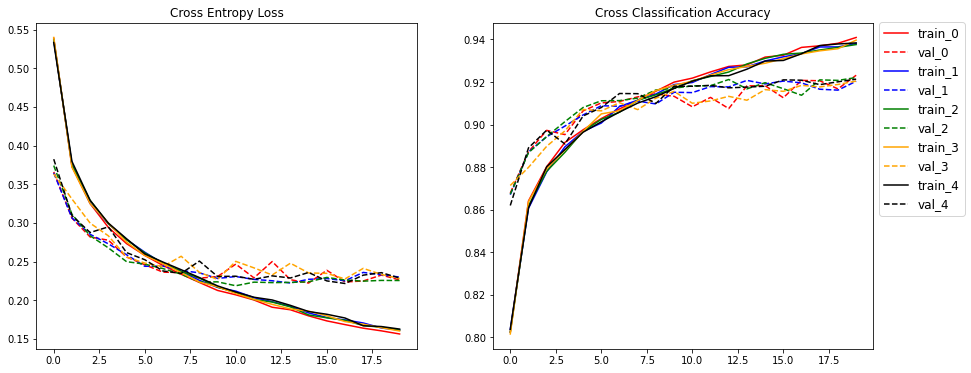

In [22]:
summarize_diagnostics(histories)

Accuracy: mean=57.454 std=34.692, n=5


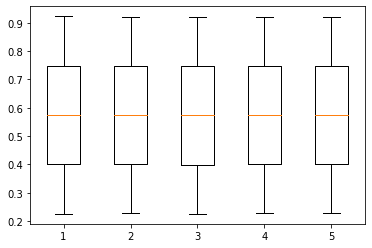

In [23]:
summarize_performance(scores)

In [24]:
model = get_first_model()
hist = model.fit(x_orig_train, y_orig_train, epochs=7, batch_size=32, verbose=0)

prediction_result(model, x_test, y_test)

Accuracy on test set: 0.912

Confusion Matrix
[[886   0  19  17   1   1  68   0   8   0]
 [  2 973   0  18   1   0   4   0   2   0]
 [ 16   0 883  10  38   0  52   0   1   0]
 [ 12   1   6 948   9   0  23   0   1   0]
 [  1   0  65  44 844   0  43   0   3   0]
 [  0   0   0   0   0 975   0  21   0   4]
 [134   0  65  25  64   0 695   0  17   0]
 [  0   0   0   0   0   8   0 982   0  10]
 [  1   0   2   4   0   2   3   3 985   0]
 [  1   0   0   0   0   4   0  49   0 946]]

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1000
           1       1.00      0.97      0.99      1000
           2       0.85      0.88      0.87      1000
           3       0.89      0.95      0.92      1000
           4       0.88      0.84      0.86      1000
           5       0.98      0.97      0.98      1000
           6       0.78      0.69      0.74      1000
           7       0.93      0.98      0.96      1000
           8 

### 3.2 Second model - Hyperparameters tuning by keras-tuner

In [25]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=self.input_shape))
        
        model.add(Conv2D(filters=32, activation='relu', kernel_size=3))
        model.add(MaxPooling2D(pool_size=2))
        
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
        
        model.add(
            Conv2D(
                filters=hp.Choice('num_filters', values=[32, 64, 128], default=64),
                activation='relu',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        
        model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        
        model.add(Flatten())
        
        model.add(
            Dense(
                units=hp.Int('units', min_value=32, max_value=512, step=32, default=128),
                activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')
            )
        )
        
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

In [26]:
from kerastuner.tuners import RandomSearch
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D

INPUT_SHAPE = (WIDTH, HEIGHT, 1)
SEED = 1
N_EPOCH_SEARCH = 40
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='fashion_mnist'
)

INFO:tensorflow:Reloading Oracle from existing project random_search/fashion_mnist/oracle.json
INFO:tensorflow:Reloading Tuner from random_search/fashion_mnist/tuner0.json


In [27]:
tuner.search_space_summary()

In [28]:
N_EPOCH_SEARCH = 40

tuner.search(
    x_train,
    y_train,
    epochs=N_EPOCH_SEARCH,
    validation_data =(x_val, y_val),
    callbacks=[early_stopping],
    verbose=0
)

INFO:tensorflow:Oracle triggered exit


In [29]:
tuner.results_summary()

In [30]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0

In [31]:
hist = model.fit( 
    x=x_train,
    y=y_train,
    epochs=50,      
    verbose=0, 
    validation_data=(x_val, y_val), 
    batch_size=50,
    callbacks=[early_stopping]
)

# final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("Hyperparameter tuning CNN Error: %.2f%%" % (100-scores[1]*100))

Hyperparameter tuning CNN Error: 7.64%


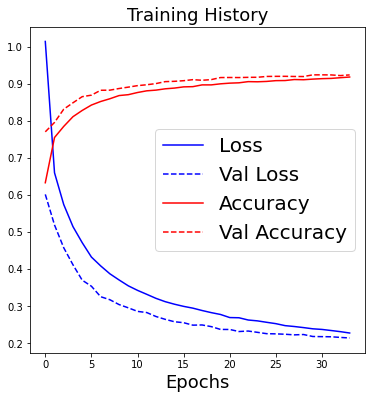

In [32]:
plot_training_history(hist)

In [33]:
prediction_result(model, x_test, y_test)

Accuracy on test set: 0.917

Confusion Matrix
[[879   1  17  18   2   1  70   0  12   0]
 [  0 982   1  13   1   0   1   0   2   0]
 [ 16   0 896  10  29   0  47   0   2   0]
 [  8   3   5 931  21   0  31   0   1   0]
 [  1   1  52  34 859   0  52   0   1   0]
 [  0   0   0   0   0 982   0  12   0   6]
 [109   0  67  24  69   0 722   0   9   0]
 [  0   0   0   0   0   8   0 978   0  14]
 [  1   1   4   4   1   2   2   2 983   0]
 [  0   0   1   0   0   5   0  37   0 957]]

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1000
           1       0.99      0.98      0.99      1000
           2       0.86      0.90      0.88      1000
           3       0.90      0.93      0.92      1000
           4       0.87      0.86      0.87      1000
           5       0.98      0.98      0.98      1000
           6       0.78      0.72      0.75      1000
           7       0.95      0.98      0.96      1000
           8 

### 3.3 Third model - Data Augmentation

In [43]:
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(WIDTH, HEIGHT, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))

model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))

model.add(Dense(NUM_CLASSES,  activation='softmax'))

# finalize the network
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)        

#### Fitting and evaluation by training and validation sets

In [44]:
#train the network
hist = model.fit(
    x=x_train,
    y=y_train,
    epochs=20,      
    validation_data=(x_val, y_val), 
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

# final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

CNN Error: 7.19%


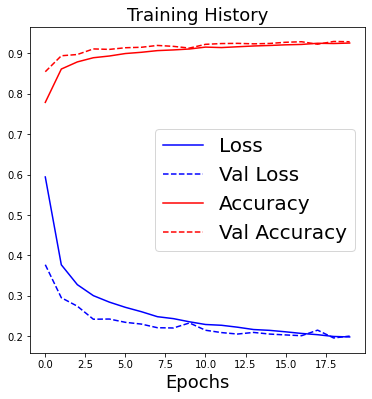

In [45]:
plot_training_history(hist)

In [46]:
prediction_result(model, x_test, y_test)

Accuracy on test set: 0.919

Confusion Matrix
[[877   0  18  14   3   1  79   0   8   0]
 [  1 987   0  10   1   0   0   0   1   0]
 [ 19   1 903   7  38   0  32   0   0   0]
 [  8   4   8 940  19   0  18   0   3   0]
 [  0   1  77  39 850   0  33   0   0   0]
 [  0   0   0   0   0 991   0   5   0   4]
 [ 96   3  75  27  64   0 727   0   8   0]
 [  0   0   0   0   0  10   0 953   0  37]
 [  1   1   0   4   2   1   0   1 990   0]
 [  1   0   0   0   0   3   0  22   0 974]]

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1000
           1       0.99      0.99      0.99      1000
           2       0.84      0.90      0.87      1000
           3       0.90      0.94      0.92      1000
           4       0.87      0.85      0.86      1000
           5       0.99      0.99      0.99      1000
           6       0.82      0.73      0.77      1000
           7       0.97      0.95      0.96      1000
           8 

#### Fitting again the existing model by generated training data and evaluation by validation set

In [47]:
datagen = ImageDataGenerator(
    rotation_range=8, width_shift_range=0.08, shear_range=0.3, height_shift_range=0.08
)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)

# fits the model on batches with real-time data augmentation:
hist = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=len(x_train) / 32,
    epochs=50,     
    validation_data=(x_val, y_val), 
    callbacks=[early_stopping],
    verbose=0
)

# Final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

CNN Error: 7.89%


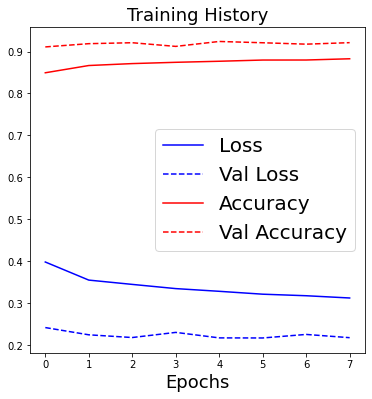

In [48]:
plot_training_history(hist)

In [49]:
prediction_result(model, x_test, y_test)

Accuracy on test set: 0.910

Confusion Matrix
[[877   1  10  11   3   1  94   0   3   0]
 [  1 992   0   6   0   0   0   0   1   0]
 [ 24   1 861   9  58   0  47   0   0   0]
 [ 25   7   9 911  22   0  25   0   1   0]
 [  1   1  50  37 845   0  64   0   2   0]
 [  0   0   0   0   0 993   0   6   0   1]
 [105   3  62  25  81   0 718   0   6   0]
 [  0   0   0   0   0  16   0 977   0   7]
 [  2   1   1   3   1   0   1   0 991   0]
 [  0   0   0   0   0   8   1  57   0 934]]

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1000
           1       0.99      0.99      0.99      1000
           2       0.87      0.86      0.86      1000
           3       0.91      0.91      0.91      1000
           4       0.84      0.84      0.84      1000
           5       0.98      0.99      0.98      1000
           6       0.76      0.72      0.74      1000
           7       0.94      0.98      0.96      1000
           8 